In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4. try sharing more encoder layers


In [ ]:
# _, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}
homology_edges, homology_scores = pickle.load(open('species_homology_info.pkl','rb'))

# adata1 = adata1[:,gene_ids[0]].copy()
# adata2 = adata2[:,gene_ids[1]].copy()
# adata3 = adata3[:,gene_ids[2]].copy()

batch_size = 256
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0,
    # yield_pairwise=True
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=1.0,
    cycle_weight=0.05,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

# Initialize the trainer

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=200,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=False,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | mu_layer        | Linear        | 16.5 K | train
1 | logvar_layer    | Linear        | 16.5 K | train
2 | encoders        | ModuleDict    | 27.0 M | train
3 | decoders        | ModuleDict    | 18.0 M | train
4 | homology_edges  | ModuleDict    | 0      | train
5 | homology_scores | ParameterDict | 1.1 M  | train
----------------------------------------------------------
46.1 M    Trainable params
0         Non-trainable params
46.1 M    Total params
184.488   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/c

Best model path: logs/metrics/version_129/checkpoints/epoch=124-step=500.ckpt


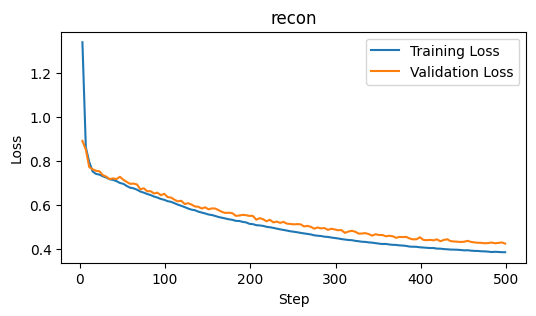

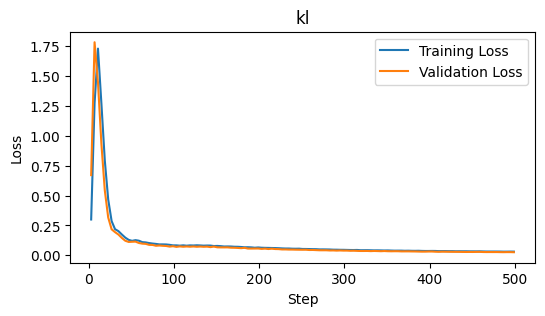

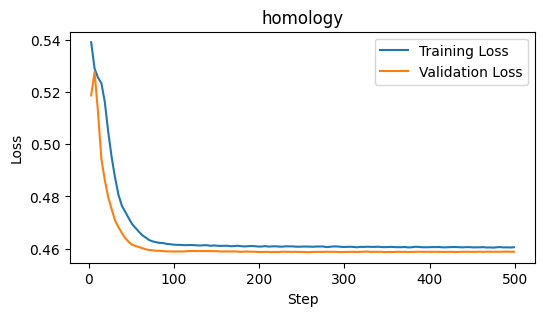

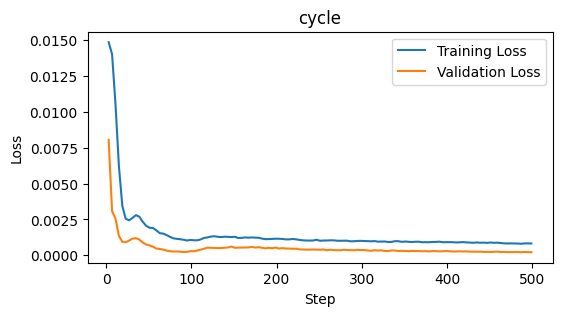

In [7]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl", "homology", "cycle"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

# Saving
# save_dict = {
#     'state_dict': model.state_dict(),
#     'hyper_parameters': model.hparams,
#     'epoch': 99,
# }
# torch.save(save_dict, f'manual_checkpoint_epoch_{99}.pt')

0.5460296726307076
0.4053677405588924
0.5742760863508798


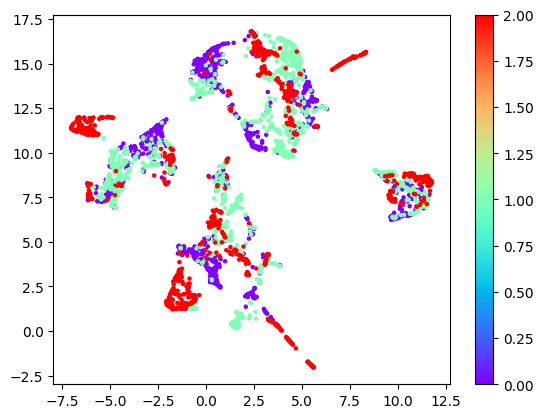

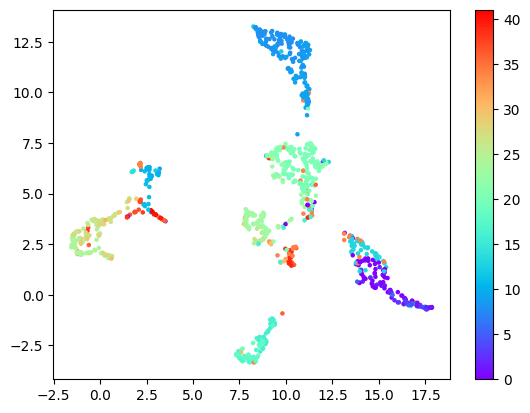

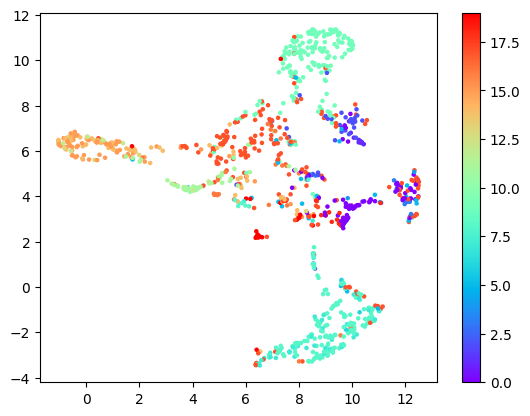

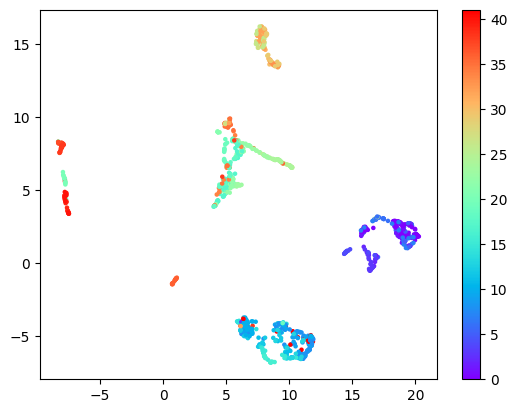

In [8]:

output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

Text(0, 0.5, 'learned scores')

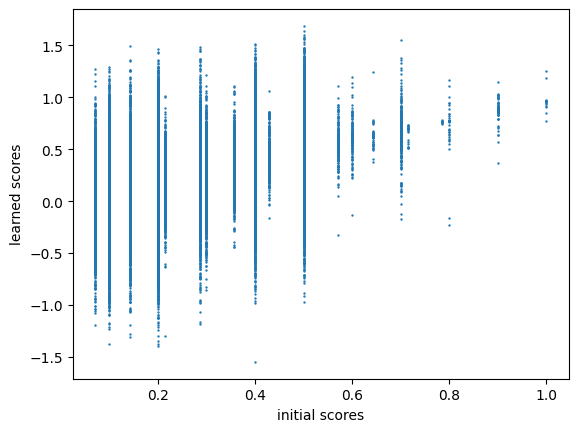

In [10]:
def sigmoid(z):
    return z#1/(1 + np.exp(-z))

x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(sigmoid(model.homology_scores[str(i)][str(j)].detach().cpu().numpy())))
        y.extend(list(sigmoid(model.homology_scores[str(j)][str(i)].detach().cpu().numpy())))
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=0.5);
plt.xlabel('initial scores');
plt.ylabel('learned scores')

In [11]:
from src.dataclasses import BatchData

batch = BatchData({i: torch.tensor(adata.X.toarray()).to('cuda') for i, adata in enumerate(species_data.values())})
model.eval()
data = []
for i in batch.data:
    row = []
    for j in batch.data:
        row_out = model.encoders[str(j)].gene_importance(model.decoders[str(j)](model.encoders[str(i)](batch.data[i])['z'])['mean'])
        row.append(row_out)
    data.append(torch.cat(row,dim=1))
data = torch.cat(data,dim=0).detach().cpu().numpy()

In [12]:
from sklearn.decomposition import PCA
pcs = PCA(n_components=50).fit_transform(data)
dt_full = umap.UMAP().fit_transform(pcs)

In [13]:
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = output.detach().cpu().numpy()[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')

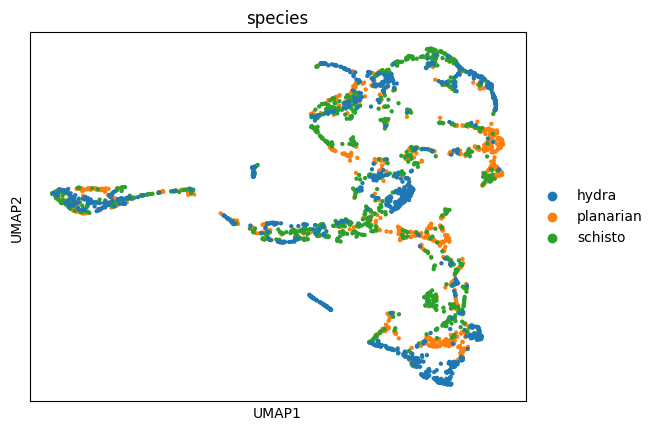

In [14]:
sc.pl.umap(adata,color='species')

In [15]:
import numpy as np
from pynndescent import NNDescent
import plotly.io as pio
pio.renderers.default = "notebook"

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

import plotly.graph_objects as go
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.io as pio
pio.renderers.default = 'notebook'
def create_sankey_from_similarity(
    similarity_matrix: np.ndarray,
    source_labels: list,
    target_labels: list,
    threshold: float = 0.1,
    title: str = "Cross-species Label Similarity",
    width: int = 1000,
    height: int = 800
) -> go.Figure:
    """
    Create a Sankey diagram from a bipartite similarity matrix with weighted edges.
    """
    # Create node labels
    labels = source_labels + target_labels
    
    # Create source, target, and value arrays for links
    sources = []
    targets = []
    values = []
    
    # Create hover text for links
    link_labels = []
    
    # Iterate through similarity matrix
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i,j] > threshold:
                sources.append(i)
                targets.append(j + len(source_labels))
                values.append(similarity_matrix[i,j])
                link_labels.append(f"{source_labels[i]} → {target_labels[j]}: {similarity_matrix[i,j]:.3f}")
    
    # Normalize values to make them more visually appealing
    values = np.array(values)
    values = values / values.max() * 100  # Scale to 0-100 range for better visualization
    
    # Create color arrays for nodes
    node_colors = ['#1f77b4'] * len(source_labels) + ['#ff7f0e'] * len(target_labels)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            customdata = link_labels,
            color = ['rgba(31, 119, 180, 0.4)'] * len(sources),  # Semi-transparent links
            hovertemplate = '%{customdata}<extra></extra>'
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=width,
        height=height,
        showlegend=False,
        margin=dict(t=40, l=40, r=40, b=40)
    )
    
    # Display in notebook
    # fig.show(renderer="notebook")
    return fig

latent = output.cpu().numpy()
indices, distances = find_nearest_neighbors(latent[s==1],latent[s==0])

cl1 = np.array(list(adata1.obs['tissue']))
cl2 = np.array(list(adata2.obs['tissue']))
cl3 = np.array(list(adata3.obs['Cluster']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)
clu3,cluc3 = np.unique(cl3, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices.flatten()]
df['labels_1'] = cl2[np.tile(np.arange(indices.shape[0])[:,None],(1,15)).flatten()]
df['distances'] = 1-distances.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['distances'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)

fig = create_sankey_from_similarity(C, list(clu1), list(clu2), threshold=0.5)

fig.write_image('t.png')

latent = pcs
indices, distances = find_nearest_neighbors(latent[s==1],latent[s==0])

cl1 = np.array(list(adata1.obs['tissue']))
cl2 = np.array(list(adata2.obs['tissue']))
cl3 = np.array(list(adata3.obs['Cluster']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)
clu3,cluc3 = np.unique(cl3, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices.flatten()]
df['labels_1'] = cl2[np.tile(np.arange(indices.shape[0])[:,None],(1,15)).flatten()]
df['distances'] = 1-distances.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['distances'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)

fig = create_sankey_from_similarity(C, list(clu1), list(clu2), threshold=0.5)

fig.write_image('t2.png')
# indices, distances = find_nearest_neighbors(latent[s==2],latent[s==0])

# SCVI

In [29]:
from src.single_vae import VAE

# Loading
# checkpoint = torch.load('manual_checkpoint_epoch_99.pt')
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,
#     homology_scores=homology_scores,
#     **checkpoint['hyper_parameters']
# )
# model.load_state_dict(checkpoint['state_dict'])
# model.eval();  # if using for inference

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=10,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_loss",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

scvi = VAE(
    cross_species_vae = model,
    n_latent = 64,
    hidden_dims = [64],
    dropout_rate = 0.2,
    base_learning_rate = 1e-3,
    base_batch_size = 32,
    batch_size = batch_size,
    min_learning_rate = 1e-5,
    warmup_epochs = 1.0,
    init_beta = 1e-3,
    final_beta = 1.0,
    gradient_clip_val = 1.0,
    gradient_clip_algorithm = "norm",  
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(scvi, data_module)

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type            | Params | Mode 
--------------------------------------------------------------
0 | cross_species_vae | CrossSpeciesVAE | 46.1 M | eval 
1 | mu_layer          | Linear          | 4.2 K  | train
2 | logvar_layer      | Linear          | 4.2 K  | train
3 | encoder           | Encoder         | 22.5 M | train
4 | decoder           | Decoder         | 9.1 M  | train
--------------------------------------------------------------
31.6 M    Trainable params
46.1 M    Non-trainable params
77.7 M    Total params
310.985   Total estimated model params size (MB)
30        Modules in train mode
97        Modules in eval mode


/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_wo

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 23.23it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 19.56it/s, v_num=24]    

Metric val_loss improved. New best score: 0.237


Epoch 1: 100%|██████████| 12/12 [00:00<00:00, 23.44it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 12/12 [00:00<00:00, 19.78it/s, v_num=24]    

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.229


Epoch 2: 100%|██████████| 12/12 [00:00<00:00, 23.55it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 12/12 [00:00<00:00, 19.82it/s, v_num=24]    

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.223


Epoch 3: 100%|██████████| 12/12 [00:00<00:00, 23.74it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 12/12 [00:00<00:00, 20.00it/s, v_num=24]    

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.219


Epoch 4: 100%|██████████| 12/12 [00:00<00:00, 23.77it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 12/12 [00:00<00:00, 19.89it/s, v_num=24]    

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.217


Epoch 5: 100%|██████████| 12/12 [00:00<00:00, 23.64it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 12/12 [00:00<00:00, 19.97it/s, v_num=24]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.217


Epoch 6: 100%|██████████| 12/12 [00:00<00:00, 23.60it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 12/12 [00:00<00:00, 19.87it/s, v_num=24]    

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.216


Epoch 7: 100%|██████████| 12/12 [00:00<00:00, 23.35it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 12/12 [00:00<00:00, 23.55it/s, v_num=24]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 12/12 [00:00<00:00, 19.86it/s, v_num=24]    

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.216


Epoch 9: 100%|██████████| 12/12 [00:00<00:00, 23.49it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 12/12 [00:00<00:00, 19.67it/s, v_num=24]    

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12/12 [00:01<00:00,  8.98it/s, v_num=24]


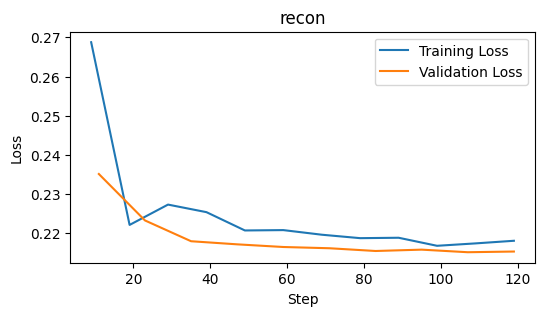

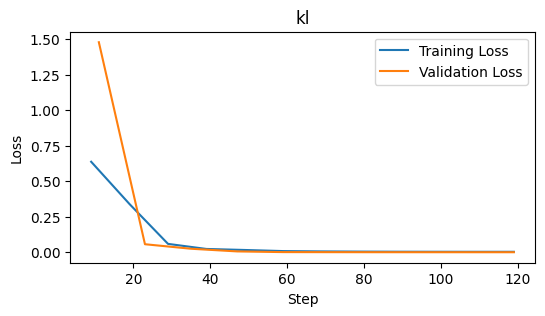

In [31]:
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon", "kl"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

0.3480677361728082
0.32661177766587485
0.5424980518507555


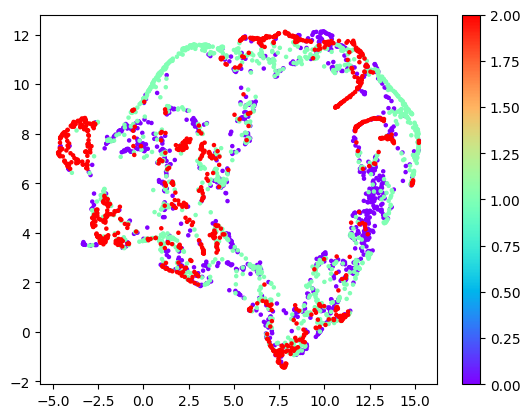

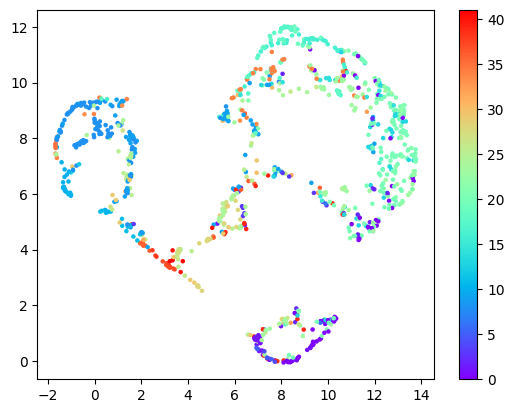

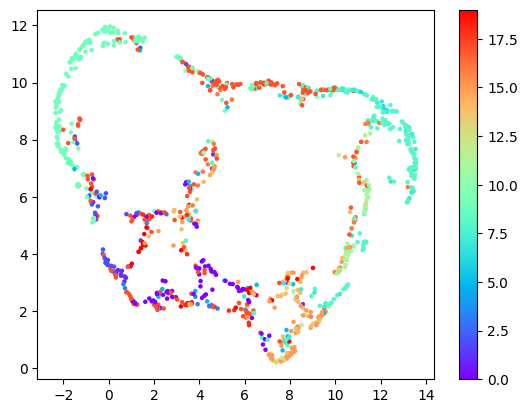

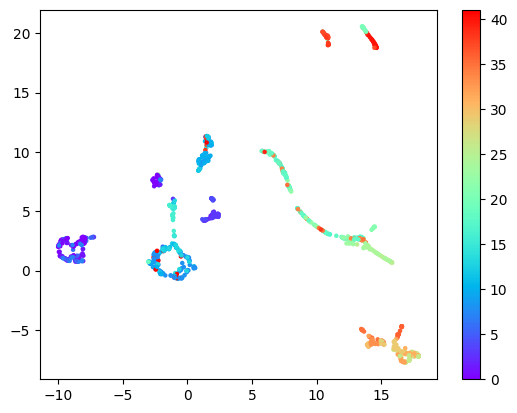

In [32]:

output = scvi.get_latent_embeddings(species_data)

s = np.array(sum([[i]*len(adata) for i, adata in enumerate([adata1, adata2, adata3])],[]))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

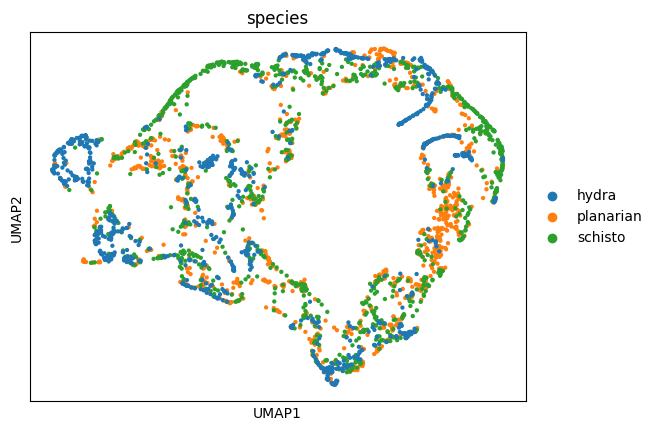

In [34]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    if 'tissue' in adata.obs:
        adata.obs[f'tissue_{k}'] = adata.obs['tissue']
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')
# plt.figure(); plt.scatter(*umap.UMAP().fit_transform(pca).T,s=1,c=s, cmap='rainbow'); plt.colorbar();
sc.pl.umap(adata, color='species')

In [20]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')

In [21]:
import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

2024-12-03 03:31:56,339 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-03 03:31:56,640 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-03 03:31:56,650 - harmonypy - INFO - Iteration 1 of 10
2024-12-03 03:31:56,980 - harmonypy - INFO - Iteration 2 of 10
2024-12-03 03:31:57,307 - harmonypy - INFO - Iteration 3 of 10
2024-12-03 03:31:57,635 - harmonypy - INFO - Iteration 4 of 10
2024-12-03 03:31:57,963 - harmonypy - INFO - Iteration 5 of 10
2024-12-03 03:31:58,290 - harmonypy - INFO - Iteration 6 of 10
2024-12-03 03:31:58,574 - harmonypy - INFO - Iteration 7 of 10
2024-12-03 03:31:58,777 - harmonypy - INFO - Iteration 8 of 10
2024-12-03 03:31:58,952 - harmonypy - INFO - Iteration 9 of 10
2024-12-03 03:31:59,135 - harmonypy - INFO - Iteration 10 of 10
2024-12-03 03:31:59,354 - harmonypy - INFO - Converged after 10 iterations


In [22]:
adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

In [ ]:
adata.write_h5ad('test.h5ad')

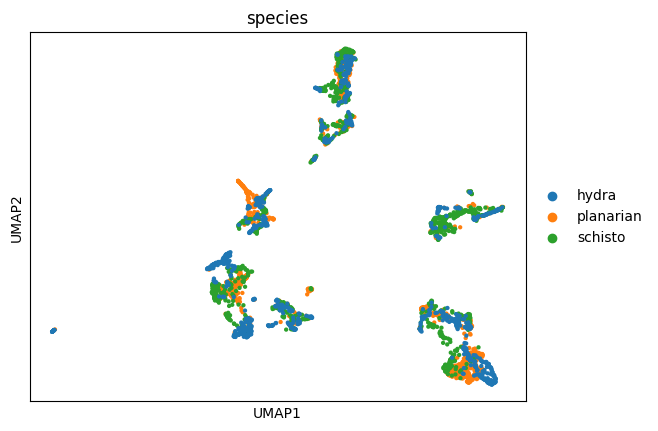

In [23]:
sc.pl.umap(adata, color ='species')

In [20]:
np.argsort(-model.homology_scores['0']['1'].detach().cpu().numpy())

array([ 71389,      0,  62378, ...,  82299,   6656, 108745])

In [23]:
adata1.var_names[7921]

'dd_Smed_v4_2215_0_1'

In [29]:
adata2.var_names[3749]

'Smp_135560'

In [28]:
homology_scores[0][1][[71389,0]]

tensor([5, 5])

In [21]:
homology_edges[0][1][[71389,0]]

tensor([[7921, 3749],
        [   0, 1232]], dtype=torch.int32)

In [10]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [11]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [19]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))

A = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
B = c2[indices]

In [26]:
a,c = np.unique(A + '--' + B,return_counts=True)
a[np.argsort(-c)]

array(['Neural--Neural', 'Neoblast--Cathepsin',
       'Epidermal--Tegument_prog', 'Epidermal--Cathepsin',
       'Epidermal--Neoblast', 'Cathepsin+ cells--Cathepsin',
       'Neoblast--Intestine', 'Neural--Parenchymal',
       'Cathepsin+ cells--Neural_KK7', 'Cathepsin+ cells--Neural',
       'Intestine--Cathepsin', 'Muscle--Parenchymal', 'Neural--Neoblast',
       'Muscle--Neural_KK7', 'Cathepsin+ cells--Parenchymal',
       'Neoblast--Muscle', 'Muscle--Neoblast', 'Neural--Muscle',
       'Pharynx--Neural', 'Muscle--Intestine', 'Neural--Flame cells',
       'Cathepsin+ cells--Intestine', 'Parapharyngeal--Muscle',
       'Intestine--Intestine', 'Neoblast--Neoblast', 'Neural--Cathepsin',
       'Protonephridia--Neural', 'Parapharyngeal--Neoblast',
       'Epidermal--Tegument', 'Muscle--Neural', 'Epidermal--Muscle',
       'Epidermal--Neural', 'Protonephridia--Cathepsin', 'Muscle--Gland',
       'Epidermal--Intestine', 'Intestine--Muscle',
       'Intestine--Tegument_prog', 'Neural--Int

In [23]:
pd.DataFrame(B[:20])

,0,1,2,3,4
0,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
1,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
2,Muscle,Intestine,Cathepsin,Cathepsin,Cathepsin
3,Cathepsin,Neoblast,Tegument_prog,Neoblast,Tegument_prog
4,Muscle,Cathepsin,Intestine,Cathepsin,Intestine
5,Muscle,Intestine,Muscle,Neural,Cathepsin
6,Cathepsin,Intestine,Cathepsin,Cathepsin,Parenchymal
7,Muscle,Neoblast,Parenchymal,Cathepsin,Neural
8,Cathepsin,Cathepsin,Intestine,Cathepsin,Cathepsin
9,Neural_KK7,Cathepsin,Gland,Neural_KK7,Parenchymal


In [15]:
B.shape

(1049, 5)

In [41]:
A1 = A[:1049].copy()
A1[i1 < 1049] = "nan"

B1 = B[:1049].copy()
B1[i1 < 1049] = "nan"

B1[:,0] = B[:1049,0]

In [46]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [43]:
pd.DataFrame(B1[(B1[:,1:]=='nan').sum(1) < 4])

,0,1,2,3,4
0,Neural: 1,nan,nan,nan,Neural: 23
1,Pharynx: 25,nan,nan,nan,Parapharyngeal: 12
2,Parapharyngeal: 12,nan,Parapharyngeal: 12,Parapharyngeal: 12,Neoblast: 0
3,Neural: 1,nan,Parapharyngeal: 12,i_smgc1,nan
4,Protonephridia: 26,Neoblast: 0,Neoblast: 0,Neoblast: 0,nan
5,Neural: 9,nan,nan,nan,Neural: 20
6,Neural: 9,nan,nan,nan,Neural: 23
7,Neoblast: 5,Muscle: 14,Muscle: 14,Muscle: 14,Muscle: 14
8,Parapharyngeal: 12,nan,nan,Parapharyngeal: 12,Muscle: 14
9,Neural: 36,nan,nan,enEp_head,nan


In [ ]:
A1

In [34]:
B1

array([['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Neoblast', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['Epidermal', 'Neural', 'Neural', 'Parenchymal', 'Neural'],
       ['Neural', 'nan', 'nan', 'nan', 'nan'],
       ['Neural', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [28]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [27]:
A1

array([['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne